In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"

In [353]:
import tensorflow as tf
from keras.layers import Dense, Input, Concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="3"

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=24220)]) #in MB

In [6]:
def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size)
    f = np.clip(f,0.0001,1-0.0001)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [7]:
def reset_weights(model):
    for layer in model.layers:         
        if hasattr(layer, 'kernel_initializer') and \
                hasattr(layer, 'bias_initializer'):
            layer.set_weights([layer.kernel_initializer(shape=np.asarray(layer.kernel.shape)), \
                layer.bias_initializer(shape=np.asarray(layer.bias.shape))])

## Gaussian case

First, no gap in phase space.

$T \sim N(\mu,\sigma)$

(I): $\mu = \mu_0, \sigma = \sigma_0$

(II): $\mu = \mu_0, \sigma = \sigma_0$

(III): $\mu = \mu_1, \sigma = \sigma_1$

$R \sim N(T+b,\epsilon)$

(I): $b = b_0, \epsilon = \epsilon_0$

(II): $b = b_1, \epsilon = \epsilon_1$

(III): $b = b_1, \epsilon = \epsilon_1$

In [8]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

inputs2 = Input((2, ))
hidden_layer_12 = Dense(50, activation='relu')(inputs2)
hidden_layer_22 = Dense(50, activation='relu')(hidden_layer_12)
hidden_layer_32 = Dense(50, activation='relu')(hidden_layer_22)
outputs2 = Dense(1, activation='sigmoid')(hidden_layer_32)
model2 = Model(inputs=inputs2, outputs=outputs2)

In [9]:
n = 1000000

mu0 = 0.
mu1 = 0.1
sigma0 = 1.5
sigma1 = 1

b0 = 0.
b1 = 0.5
eps0 = 0.5
eps1 = 0.3

T0 = np.random.normal(mu0,sigma0,n)
T1 = np.random.normal(mu0,sigma0,n)

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [10]:
#First, conditional reweighting
reset_weights(model)

xvals_1 = np.concatenate([T1,T0])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

reset_weights(model2)

xvals_1 = np.concatenate([np.c_[T1,R1],np.c_[T0,R0]])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
h = model2.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1))

wT = reweight(T2,model)
wRT = reweight(np.c_[T2,R2],model2)
wRTa = reweight(np.c_[T1,R1],model2)

#Next, marginal reweighting
reset_weights(model)

xvals_1 = np.concatenate([T2,T0])
yvals_1 = np.concatenate([np.ones(len(T2)),np.zeros(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

wT0 = reweight(T0,model)

Epoch 1/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6933 - accuracy: 0.5006 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 2/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4996
Epoch 4/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 5/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.4996
Epoch 6/20
1500/1500 [==============================] - 4s 3ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy: 0.5004
Epoch 7/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy:

Epoch 18/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6563 - accuracy: 0.5969 - val_loss: 0.6557 - val_accuracy: 0.5978
Epoch 19/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6563 - accuracy: 0.5971 - val_loss: 0.6558 - val_accuracy: 0.5980
Epoch 20/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6563 - accuracy: 0.5969 - val_loss: 0.6557 - val_accuracy: 0.5983


In [11]:
Tt_copy = Tt.copy()
T0_copy = T0.copy()
T1_copy = T1.copy()
T2_copy = T2.copy()
wT0_copy = wT0.copy()

Rt_copy = Rt.copy()
R0_copy = R0.copy()
R1_copy = R1.copy()
R2_copy = R2.copy()
wRT_copy = wRT.copy()
wT_copy = wT.copy()

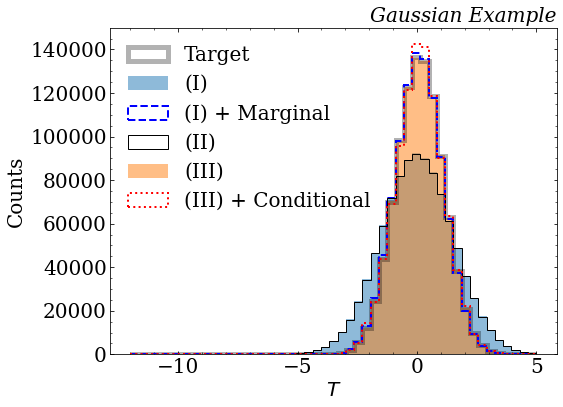

In [76]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Tt_copy,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(T0_copy,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(T0_copy,weights=wT0_copy,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(T1_copy,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(T2_copy,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(T2_copy,weights=wRT_copy/wT_copy,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$T$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Gaussian_T.pdf",bbox_inches='tight')

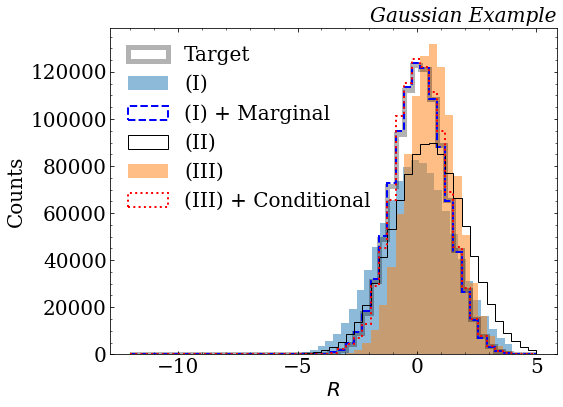

In [77]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Rt_copy,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(R0_copy,bins=np.linspace(-12,4,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(R0_copy,weights=wT0_copy,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(R1_copy,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(R2_copy,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(R2_copy,weights=wRT_copy/wT_copy,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$R$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Gaussian_R.pdf",bbox_inches='tight')

In [24]:
n = 1000000

mu0 = 0.
mu1 = 0.3
sigma0 = 1.5
sigma1 = 1.8

b0 = 0.
b1 = 0.2
eps0 = 0.5
eps1 = 0.3

T0 = np.random.normal(mu0,sigma0,n*5)
T1 = np.random.normal(mu0,sigma0,n*5)

T1 = T1[(T1 < 1.5) + (T1 > 2)]
T1 = T1[0:n]

T0 = T0[(T0 < 1.5) + (T0 > 2)]
T0 = T0[0:n]

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [25]:
#First, conditional reweighting
reset_weights(model)

xvals_1 = np.concatenate([T1,T0])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

reset_weights(model2)

xvals_1 = np.concatenate([np.c_[T1,R1],np.c_[T0,R0]])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
h = model2.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1))

wT = reweight(T2,model)
wRT = reweight(np.c_[T2,R2],model2)
wRTa = reweight(np.c_[T1,R1],model2)

#Next, marginal reweighting
reset_weights(model)

xvals_1 = np.concatenate([T2,T0])
yvals_1 = np.concatenate([np.ones(len(T2)),np.zeros(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

wT0 = reweight(T0,model)

Epoch 1/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5004
Epoch 2/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6932 - val_accuracy: 0.5001
Epoch 3/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 4/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5003
Epoch 5/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 6/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 7/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy:

Epoch 18/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6537 - accuracy: 0.5814 - val_loss: 0.6528 - val_accuracy: 0.5815
Epoch 19/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6537 - accuracy: 0.5815 - val_loss: 0.6531 - val_accuracy: 0.5818
Epoch 20/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6537 - accuracy: 0.5815 - val_loss: 0.6529 - val_accuracy: 0.5816


In [26]:
Tt_copy2 = Tt.copy()
T0_copy2 = T0.copy()
T1_copy2 = T1.copy()
T2_copy2 = T2.copy()
wT0_copy2 = wT0.copy()

Rt_copy2 = Rt.copy()
R0_copy2 = R0.copy()
R1_copy2 = R1.copy()
R2_copy2 = R2.copy()
wRT_copy2 = wRT.copy()
wT_copy2 = wT.copy()

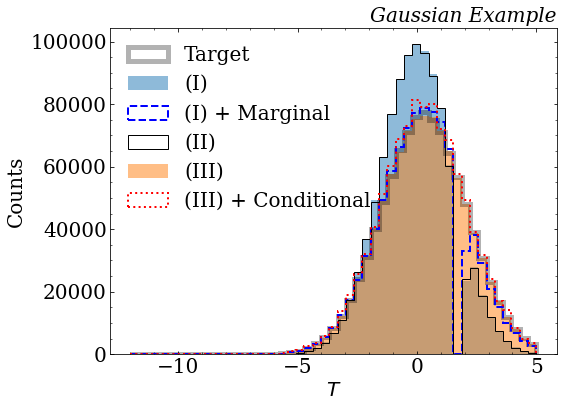

In [78]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Tt_copy2,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(T0_copy2,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(T0_copy2,weights=wT0_copy2,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(T1_copy2,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(T2_copy2,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(T2_copy2,weights=wRT_copy2/wT_copy2,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$T$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Gaussian_T_withhole.pdf",bbox_inches='tight')

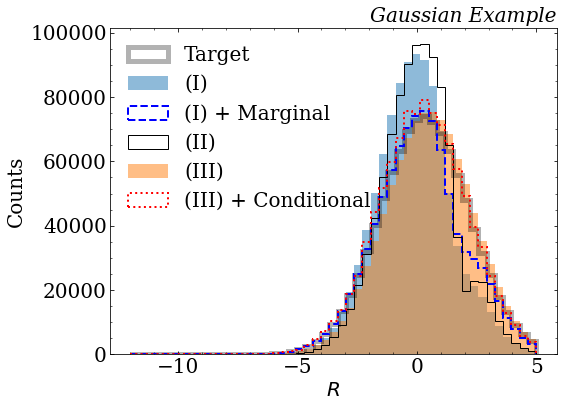

In [79]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Rt_copy2,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(R0_copy2,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(R0_copy2,weights=wT0_copy2,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(R1_copy2,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(R2_copy2,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(R2_copy2,weights=wRT_copy2/wT_copy2,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$R$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Gaussian_R_withhole.pdf",bbox_inches='tight')

In [19]:
n = 1000000

mu0 = 0
mu1 = 2 #scan this
sigma0 = 0.5
sigma1 = 0.5

b0 = 0
b1 = 0
eps0 = 0.3 #scan this
eps1 = 0.4

T0 = np.random.normal(mu0,sigma0,n)
T1 = np.random.normal(mu0,sigma0,n)

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [20]:
#First, conditional reweighting
reset_weights(model)

xvals_1 = np.concatenate([T1,T0])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

reset_weights(model2)

xvals_1 = np.concatenate([np.c_[T1,R1],np.c_[T0,R0]])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
h = model2.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1))

wT = reweight(T2,model)
wRT = reweight(np.c_[T2,R2],model2)
wRTa = reweight(np.c_[T1,R1],model2)

#Next, marginal reweighting
reset_weights(model)

xvals_1 = np.concatenate([T2,T0])
yvals_1 = np.concatenate([np.ones(len(T2)),np.zeros(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

wT0 = reweight(T0,model)

Epoch 1/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5008
Epoch 2/20
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.4993
Epoch 3/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5002 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 4/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.4995
Epoch 5/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 6/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5005
Epoch 7/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6931 - val_accuracy:

Epoch 18/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0606 - accuracy: 0.9773 - val_loss: 0.0605 - val_accuracy: 0.9774
Epoch 19/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0606 - accuracy: 0.9774 - val_loss: 0.0605 - val_accuracy: 0.9774
Epoch 20/20
1500/1500 [==============================] - 4s 2ms/step - loss: 0.0606 - accuracy: 0.9774 - val_loss: 0.0608 - val_accuracy: 0.9774


In [21]:
Tt_copy3 = Tt.copy()
T0_copy3 = T0.copy()
T1_copy3 = T1.copy()
T2_copy3 = T2.copy()
wT0_copy3 = wT0.copy()

Rt_copy3 = Rt.copy()
R0_copy3 = R0.copy()
R1_copy3 = R1.copy()
R2_copy3 = R2.copy()
wRT_copy3 = wRT.copy()
wT_copy3 = wT.copy()

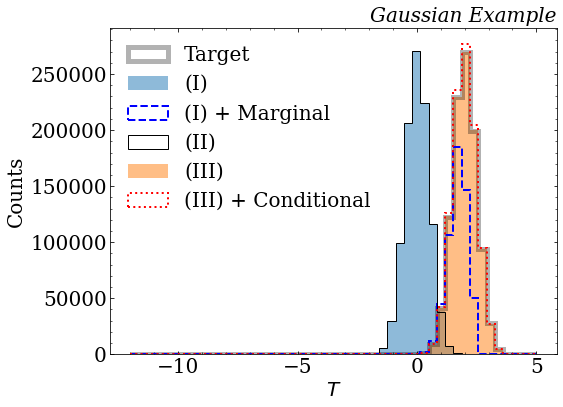

In [80]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Tt_copy3,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(T0_copy3,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(T0_copy3,weights=wT0_copy3,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(T1_copy3,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(T2_copy3,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(T2_copy3,weights=wRT_copy3/wT_copy3,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$T$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Gaussian_T_onedge.pdf",bbox_inches='tight')

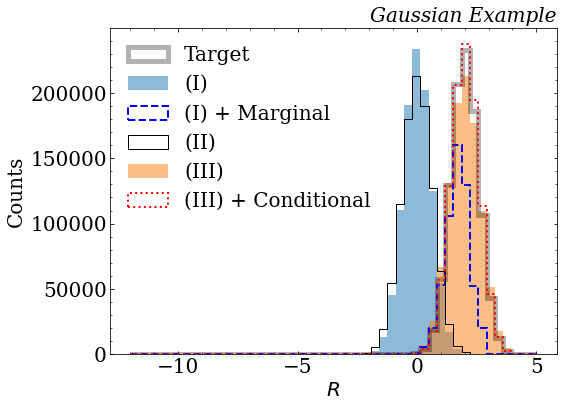

In [81]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Rt_copy3,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(R0_copy3,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(R0_copy3,weights=wT0_copy3,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(R1_copy3,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(R2_copy3,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(R2_copy3,weights=wRT_copy3/wT_copy3,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$R$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Gaussian_R_onedge.pdf",bbox_inches='tight')

## Now try a physics example

In [29]:
import energyflow as ef

/global/home/users/bpnachman/anaconda3/envs/tf2/lib/python3.8/site-packages/energyflow/emd.py:915: UserWarning: emd module requires 'wasserstein' or 'pot', both of which are unavailable
  warnings.warn(message)


In [301]:
sim = ef.mod.load(dataset='sim',subdatasets=["SIM1000_Jet300_pT375-infGeV"])

In [302]:
gen = ef.mod.load(dataset='gen',subdatasets=["GEN1000_pT375-infGeV"])

In [303]:
sim14 = ef.mod.load(dataset='sim',subdatasets=["SIM1400_Jet300_pT375-infGeV"])
sim18 = ef.mod.load(dataset='sim',subdatasets=["SIM1800_Jet300_pT375-infGeV"])

In [304]:
gen14 = ef.mod.load(dataset='gen',subdatasets=["GEN1400_pT375-infGeV"])
gen18 = ef.mod.load(dataset='gen',subdatasets=["GEN1800_pT375-infGeV"])

In [310]:
simjets_f = sim.jets_f[0:20000]
sim14jets_f = sim14.jets_f[0:20000]
sim18jets_f = sim18.jets_f[0:20000]

In [311]:
myfile = open("output.text")
delphes = []
for line in myfile:
    delphes+=[[float(line.split()[0]),float(line.split()[1]),
               float(line.split()[2]),float(line.split()[3]),
               float(line.split()[4]),float(line.split()[5]),
               float(line.split()[6]),float(line.split()[7]),
               float(line.split()[8]),float(line.split()[9])]]
delphes = np.array(delphes)

myfile = open("output14.text")
delphes14 = []
for line in myfile:
    delphes14+=[[float(line.split()[0]),float(line.split()[1]),
               float(line.split()[2]),float(line.split()[3]),
               float(line.split()[4]),float(line.split()[5]),
               float(line.split()[6]),float(line.split()[7]),
               float(line.split()[8]),float(line.split()[9])]]
delphes14 = np.array(delphes14)

myfile = open("output18.text")
delphes18 = []
for line in myfile:
    delphes18+=[[float(line.split()[0]),float(line.split()[1]),
               float(line.split()[2]),float(line.split()[3]),
               float(line.split()[4]),float(line.split()[5]),
               float(line.split()[6]),float(line.split()[7]),
               float(line.split()[8]),float(line.split()[9])]]
delphes18 = np.array(delphes18)

In [312]:
len(delphes)

19999

In [313]:
len(gen14)

100000

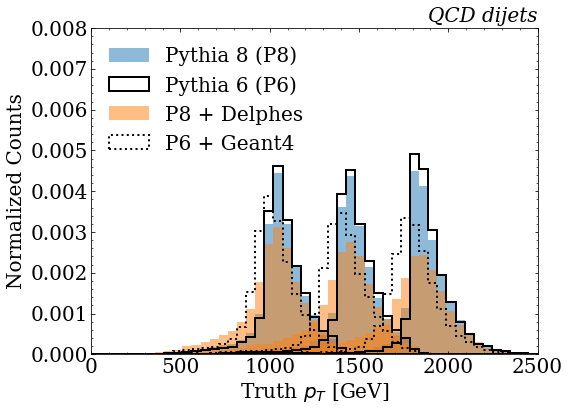

In [314]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(delphes[:,6],density=True,alpha=0.5,bins=np.linspace(0,2500,50),label="Pythia 8 (P8)")
_,_,_=plt.hist(delphes14[:,6],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:blue")
_,_,_=plt.hist(delphes18[:,6],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:blue")
_,_,_=plt.hist(simjets_f[:,8],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",lw=2,label="Pythia 6 (P6)")
_,_,_=plt.hist(sim14jets_f[:,8],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",lw=2)
_,_,_=plt.hist(sim18jets_f[:,8],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",lw=2)

_,_,_=plt.hist(delphes[:,1],density=True,alpha=0.5,bins=np.linspace(0,2500,50),label="P8 + Delphes")
_,_,_=plt.hist(delphes14[:,1],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:orange")
_,_,_=plt.hist(delphes18[:,1],density=True,alpha=0.5,bins=np.linspace(0,2500,50),color="tab:orange")
_,_,_=plt.hist(simjets_f[:,0],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",ls=":",lw=2,label="P6 + Geant4")
_,_,_=plt.hist(sim14jets_f[:,0],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",ls=":",lw=2)
_,_,_=plt.hist(sim18jets_f[:,0],density=True,bins=np.linspace(0,2500,50),histtype="step",color="black",ls=":",lw=2)

plt.ylim([0,0.008])
#plt.yscale("log")
plt.xlim([0,2500])
plt.xlabel("Truth $p_T$ [GeV]")
plt.ylabel("Normalized Counts")
plt.legend(frameon=False,fontsize=20,loc="upper left")
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_pT_more.pdf",bbox_inches='tight')

In [315]:
inputsP = Input((1, ))
hiddenP_layer_1 = Dense(50, activation='relu')(inputsP)
hiddenP_layer_2 = Dense(50, activation='relu')(hiddenP_layer_1)
hiddenP_layer_3 = Dense(50, activation='relu')(hiddenP_layer_2)
outputsP = Dense(1, activation='sigmoid')(hiddenP_layer_3)
modelP = Model(inputs=inputsP, outputs=outputsP)

inputsP2 = Input((2, ))
hiddenP_layer_12 = Dense(50, activation='relu')(inputsP2)
hiddenP_layer_22 = Dense(50, activation='relu')(hiddenP_layer_12)
hiddenP_layer_32 = Dense(50, activation='relu')(hiddenP_layer_22)
outputsP2 = Dense(1, activation='sigmoid')(hiddenP_layer_32)
modelP2 = Model(inputs=inputsP2, outputs=outputsP2)

inputsM = Input((1, ))
hiddenM_layer_1 = Dense(50, activation='relu')(inputsM)
hiddenM_layer_2 = Dense(50, activation='relu')(hiddenM_layer_1)
hiddenM_layer_3 = Dense(50, activation='relu')(hiddenM_layer_2)
outputsM = Dense(1, activation='sigmoid')(hiddenM_layer_3)
modelM = Model(inputs=inputsM, outputs=outputsM)

In [321]:
#Conditional

xvals_1 = np.concatenate([simjets_f[:,8],delphes[:,6],sim18jets_f[:,8],delphes18[:,6]])
yvals_1 = np.concatenate([np.ones(len(simjets_f[:,8])),np.zeros(len(delphes[:,6])),np.ones(len(sim18jets_f[:,8])),np.zeros(len(delphes18[:,6]))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

reset_weights(modelP)
modelP.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
hp = modelP.fit(X_train_1/1000.,
          Y_train_1,
          epochs=50,
          batch_size=1000,
          validation_data=(X_test_1/1000., Y_test_1))

xvals_1 = np.concatenate([np.c_[simjets_f[:,8],simjets_f[:,0]],np.c_[delphes[:,6],delphes[:,1]],np.c_[sim18jets_f[:,8],sim18jets_f[:,0]],np.c_[delphes18[:,6],delphes18[:,1]]])
yvals_1 = np.concatenate([np.ones(len(simjets_f[:,8])),np.zeros(len(delphes[:,6])),np.ones(len(sim18jets_f[:,8])),np.zeros(len(delphes18[:,6]))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

reset_weights(modelP2)
modelP2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
modelP2.fit(X_train_1/1000.,
          Y_train_1,
          epochs=50,
          batch_size=1000,
          validation_data=(X_test_1/1000., Y_test_1))

#Marginal:

xvals_1 = np.concatenate([simjets_f[:,8],delphes[:,6],delphes14[:,6],sim18jets_f[:,8],delphes18[:,6]])
yvals_1 = np.concatenate([np.zeros(len(simjets_f[:,8])),np.ones(len(delphes[:,6])),np.ones(len(delphes14[:,6])),np.zeros(len(sim18jets_f[:,8])),np.ones(len(delphes18[:,6]))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

reset_weights(modelM)
modelM.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
hm = modelM.fit(X_train_1/1000.,
          Y_train_1,
          epochs=50,
          batch_size=1000,
          validation_data=(X_test_1/1000., Y_test_1))

Epoch 1/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6930 - val_accuracy: 0.5065
Epoch 2/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.5008 - val_loss: 0.6930 - val_accuracy: 0.5084
Epoch 3/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5022 - val_loss: 0.6928 - val_accuracy: 0.5111
Epoch 4/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5027 - val_loss: 0.6927 - val_accuracy: 0.4996
Epoch 5/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.5037 - val_loss: 0.6926 - val_accuracy: 0.5003
Epoch 6/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5022 - val_loss: 0.6924 - val_accuracy: 0.5086
Epoch 7/50
60/60 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5011 - val_loss: 0.6924 - val_accuracy: 0.5085
Epoch 8/50
60/60 [==

60/60 [==============================] - 0s 3ms/step - loss: 0.6150 - accuracy: 0.6723 - val_loss: 0.6119 - val_accuracy: 0.6771
Epoch 10/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6132 - accuracy: 0.6738 - val_loss: 0.6105 - val_accuracy: 0.6793
Epoch 11/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6135 - accuracy: 0.6715 - val_loss: 0.6096 - val_accuracy: 0.6775
Epoch 12/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6125 - accuracy: 0.6713 - val_loss: 0.6132 - val_accuracy: 0.6741
Epoch 13/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.6724 - val_loss: 0.6098 - val_accuracy: 0.6757
Epoch 14/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6136 - accuracy: 0.6701 - val_loss: 0.6083 - val_accuracy: 0.6797
Epoch 15/50
60/60 [==============================] - 0s 3ms/step - loss: 0.6124 - accuracy: 0.6717 - val_loss: 0.6081 - val_accuracy: 0.6797
Epoch 16/50
60/60 [======

75/75 [==============================] - 0s 3ms/step - loss: 0.5913 - accuracy: 0.6066 - val_loss: 0.5929 - val_accuracy: 0.6071
Epoch 18/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5908 - accuracy: 0.6076 - val_loss: 0.5930 - val_accuracy: 0.5968
Epoch 19/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5906 - accuracy: 0.6068 - val_loss: 0.5931 - val_accuracy: 0.5933
Epoch 20/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5914 - accuracy: 0.6052 - val_loss: 0.5927 - val_accuracy: 0.5956
Epoch 21/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.6076 - val_loss: 0.5929 - val_accuracy: 0.5964
Epoch 22/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5905 - accuracy: 0.6080 - val_loss: 0.5929 - val_accuracy: 0.6037
Epoch 23/50
75/75 [==============================] - 0s 3ms/step - loss: 0.5906 - accuracy: 0.6054 - val_loss: 0.5917 - val_accuracy: 0.6086
Epoch 24/50
75/75 [======

In [322]:
wTP = reweight(np.concatenate([delphes[:,6],delphes14[:,6],delphes18[:,6]])/1000.,modelP)
wRTP = reweight(np.concatenate([np.c_[delphes[:,6],delphes[:,1]],np.c_[delphes14[:,6],delphes14[:,1]],np.c_[delphes18[:,6],delphes18[:,1]]])/1000.,modelP2)
wTG = reweight(np.concatenate([simjets_f[:,8],sim18jets_f[:,8]])/1000.,modelM)

<ipython-input-330-91050eb7e823>:30: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(Delphes_R_tot/Delphes_T_tot,alpha=0.5,bins=np.linspace(0,1.5,50),density=True,label="P8 + Delphes",color="tab:orange")


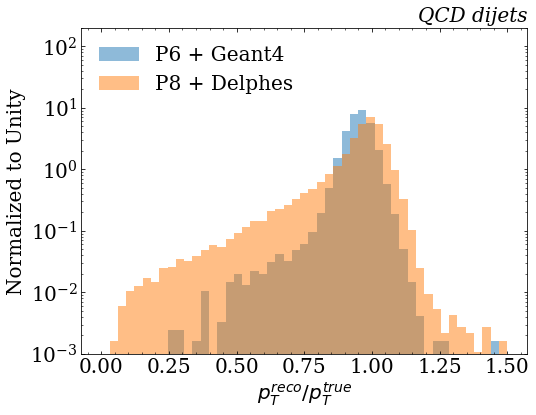

In [330]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

G4_T_tot = np.concatenate([simjets_f[:,8],sim18jets_f[:,8]])
Delphes_T_tot = np.concatenate([delphes[:,6],delphes14[:,6],delphes18[:,6]])

G4_R_tot = np.concatenate([simjets_f[:,0],sim18jets_f[:,0]])
Delphes_R_tot = np.concatenate([delphes[:,1],delphes14[:,1],delphes18[:,1]])

#wTG_tot = wTG[(G4_T_tot < 1600)*(G4_T_tot > 1400)]

#wRTP_tot = wRTP[(Delphes_T_tot < 1600)*(Delphes_T_tot > 1400)]
#wTP_tot = wTP[(Delphes_T_tot < 1600)*(Delphes_T_tot > 1400)]

#G4_R_tot = G4_R_tot[(G4_T_tot < 1600)*(G4_T_tot > 1400)]
#G4_T_tot = G4_T_tot[(G4_T_tot < 1600)*(G4_T_tot > 1400)]

#Delphes_R_tot = Delphes_R_tot[(Delphes_T_tot < 1600)*(Delphes_T_tot > 1400)]
#Delphes_T_tot = Delphes_T_tot[(Delphes_T_tot < 1600)*(Delphes_T_tot > 1400)]

plt.hist(G4_R_tot/G4_T_tot,bins=np.linspace(0,1.5,50),density=True,label="P6 + Geant4",color="tab:blue",alpha=0.5)
#plt.hist(G4_R_tot/G4_T_tot,bins=np.linspace(0,2,50),density=True,label="P6 + Geant4 + Marginal",histtype="step",lw=2,ls="--",color="blue",weights=1./wTG_tot)
plt.hist(Delphes_R_tot/Delphes_T_tot,alpha=0.5,bins=np.linspace(0,1.5,50),density=True,label="P8 + Delphes",color="tab:orange")
#plt.hist(Delphes_R_tot/Delphes_T_tot,bins=np.linspace(0,2,50),density=True,label="P8 + Delphes + Conditional",color="red",histtype="step",ls=":",weights=wRTP_tot/wTP_tot,lw=2)
plt.xlabel("$p_T^{reco}/p_T^{true}$")
plt.ylabel("Normalized to Unity")
plt.yscale("log")
plt.legend(frameon=False,loc="upper left")
plt.ylim([1e-3,200])
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_response_pT.pdf",bbox_inches='tight')

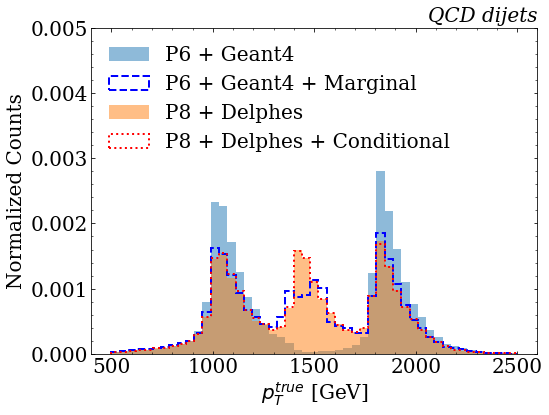

In [333]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)
ax0.minorticks_on()

plt.hist(np.concatenate([simjets_f[:,8],sim18jets_f[:,8]]),bins=np.linspace(500,2500,50),label="P6 + Geant4",color="tab:blue",alpha=0.5,density=True)
plt.hist(np.concatenate([simjets_f[:,8],sim18jets_f[:,8]]),bins=np.linspace(500,2500,50),label="P6 + Geant4 + Marginal",histtype="step",color="blue",weights=wTG,ls="--",lw=2,density=True)
plt.hist(np.concatenate([delphes[:,6],delphes14[:,6],delphes18[:,6]]),bins=np.linspace(500,2500,50),label="P8 + Delphes",color="tab:orange",alpha=0.5,density=True)
plt.hist(np.concatenate([delphes[:,6],delphes14[:,6],delphes18[:,6]]),bins=np.linspace(500,2500,50),label="P8 + Delphes + Conditional",color="red",histtype="step",ls=":",weights=wRTP/wTP,lw=2,density=True)
plt.xlabel("$p_T^{true}$ [GeV]")
plt.ylabel("Normalized Counts")
#plt.yscale("log")
plt.legend(frameon=False,loc="upper left")
#plt.ylim([1,1e8])
plt.ylim([0,0.005])
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_T_pT.pdf",bbox_inches='tight')

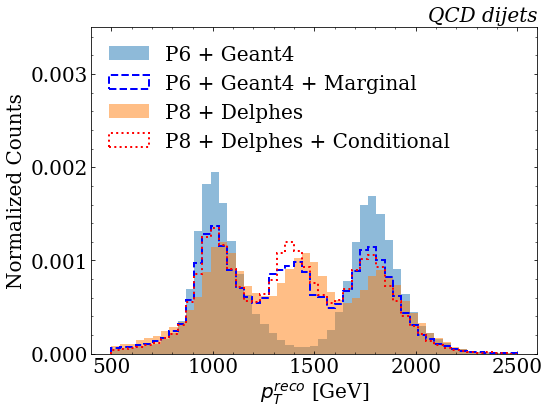

In [334]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)
ax0.minorticks_on()

plt.hist(np.concatenate([simjets_f[:,0],sim18jets_f[:,0]]),bins=np.linspace(500,2500,50),label="P6 + Geant4",color="tab:blue",alpha=0.5,density=True)
plt.hist(np.concatenate([simjets_f[:,0],sim18jets_f[:,0]]),bins=np.linspace(500,2500,50),label="P6 + Geant4 + Marginal",histtype="step",color="blue",weights=wTG,ls="--",lw=2,density=True)
plt.hist(np.concatenate([delphes[:,1],delphes14[:,1],delphes18[:,1]]),bins=np.linspace(500,2500,50),label="P8 + Delphes",color="tab:orange",alpha=0.5,density=True)
plt.hist(np.concatenate([delphes[:,1],delphes14[:,1],delphes18[:,1]]),bins=np.linspace(500,2500,50),label="P8 + Delphes + Conditional",color="red",histtype="step",ls=":",weights=wRTP/wTP,lw=2,density=True)
plt.xlabel("$p_T^{reco}$ [GeV]")
plt.ylabel("Normalized Counts")
#plt.yscale("log")
plt.legend(frameon=False,loc="upper left")
#plt.ylim([1,1e8])
plt.ylim([0,0.0035])
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_R_pT.pdf",bbox_inches='tight')

## Try to do the learning all at once.

In [404]:
n = 1000000

mu0 = 0.
mu1 = 0.
sigma0 = 0.5
sigma1 = 0.5

b0 = 0.
b1 = 0.0
eps0 = 0.3
eps1 = 0.8

T0 = np.random.normal(mu0,sigma0,n*5)
T1 = np.random.normal(mu0,sigma0,n*5)

#T1 = T1[(T1 < 1.5) + (T1 > 2)]
T1 = T1[0:n]

#T0 = T0[(T0 < 1.5) + (T0 > 2)]
T0 = T0[0:n]

T2 = np.random.normal(mu1,sigma1,n)
Tt = np.random.normal(mu1,sigma1,n)

R0 = np.random.normal(T0+b0,eps0)
R1 = np.random.normal(T1+b1,eps1)
R2 = np.random.normal(T2+b1,eps1)
Rt = np.random.normal(Tt+b0,eps0)

In [410]:
#Make the 4d data for the special training

x = []
y = []
xprime = []
for i in range(len(T0)):
    x+=[[R0[i],T0[i],T1[i]]]
    x+=[[R1[i],T0[i],T1[i]]]
    xprime+=[[R2[i],T2[i],T2[i]]]
    y+=[0]
    y+=[1]

In [367]:
inputsO = Input((3, ))
hidden_layer_1O = Dense(50, activation='relu')(inputsO)
hidden_layer_2O = Dense(50, activation='relu')(hidden_layer_1O)
hidden_layer_3O = Dense(50, activation='relu')(hidden_layer_2O)
outputsO = Dense(1, activation='sigmoid')(hidden_layer_3O)
modelO = Model(inputs=inputsO, outputs=outputsO)

In [ ]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(x, y)

reset_weights(modelO)
modelO.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
modelO.fit(X_train_1,
          Y_train_1,
          epochs=5,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

In [ ]:
wO = modelO.predict(xprime,batch_size=1000)
wO = wO/(1.-wO)

In [ ]:
_,_,_=plt.hist(Rt,bins=np.linspace(-5,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3,density=True)
_,_,_=plt.hist(R2,bins=np.linspace(-5,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,density=True)
_,_,_=plt.hist(R2,weights=wO,bins=np.linspace(-5,5,50),label="(III) + Conditional",histtype="step",color="black",lw=2,ls=":",density=True)

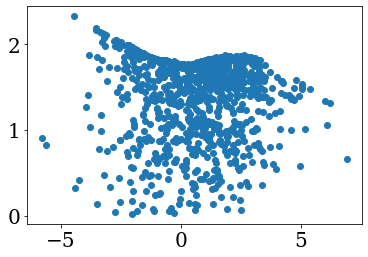

In [389]:
plt.scatter(R2[0:1000],wO[0:1000])

In [337]:
#First, conditional reweighting
reset_weights(model)

xvals_1 = np.concatenate([T1,T0])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=2,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

reset_weights(model2)

xvals_1 = np.concatenate([np.c_[T1,R1],np.c_[T0,R0]])
yvals_1 = np.concatenate([np.zeros(len(T1)),np.ones(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
h = model2.fit(X_train_1,
          Y_train_1,
          epochs=2,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1))

wT = reweight(T2,model)
wRT = reweight(np.c_[T2,R2],model2)
wRTa = reweight(np.c_[T1,R1],model2)

#Next, marginal reweighting
reset_weights(model)

xvals_1 = np.concatenate([T2,T0])
yvals_1 = np.concatenate([np.ones(len(T2)),np.zeros(len(T0))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

model.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
model.fit(X_train_1,
          Y_train_1,
          epochs=2,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1),verbose=True)

wT0 = reweight(T0,model)

Epoch 1/2
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 2/2
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 1/2
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6193 - accuracy: 0.6440 - val_loss: 0.6157 - val_accuracy: 0.6472
Epoch 2/2
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6160 - accuracy: 0.6468 - val_loss: 0.6155 - val_accuracy: 0.6470
Epoch 1/2
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6714 - accuracy: 0.5789 - val_loss: 0.6624 - val_accuracy: 0.5813
Epoch 2/2
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6588 - accuracy: 0.5810 - val_loss: 0.6570 - val_accuracy: 0.5818


In [338]:
Tt_copy22 = Tt.copy()
T0_copy22 = T0.copy()
T1_copy22 = T1.copy()
T2_copy22 = T2.copy()
wT0_copy22 = wT0.copy()

Rt_copy22 = Rt.copy()
R0_copy22 = R0.copy()
R1_copy22 = R1.copy()
R2_copy22 = R2.copy()
wRT_copy22 = wRT.copy()
wT_copy22 = wT.copy()

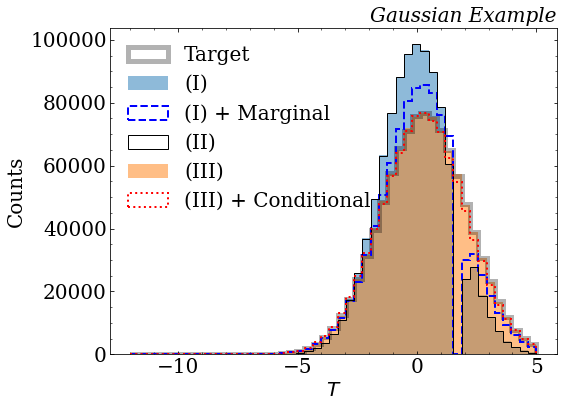

In [339]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Tt_copy22,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(T0_copy22,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(T0_copy22,weights=wT0_copy22,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(T1_copy22,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(T2_copy22,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(T2_copy22,weights=wRT_copy22/wT_copy22,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$T$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
#plt.savefig("conditional/Gaussian_T_withhole.pdf",bbox_inches='tight')

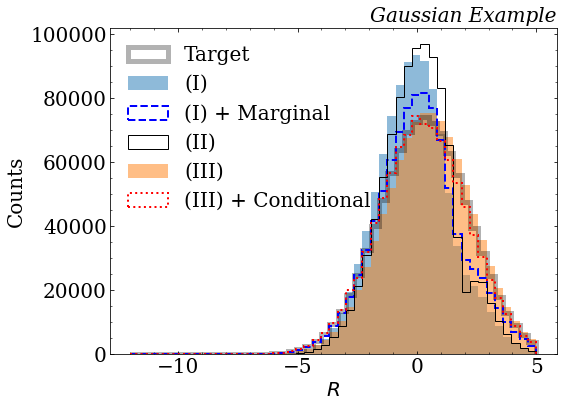

In [340]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(Rt_copy22,bins=np.linspace(-12,5,50),label="Target",histtype="step",color="black",lw=5,alpha=0.3)
_,_,_=plt.hist(R0_copy22,bins=np.linspace(-12,5,50),alpha=0.5,label="(I)")
_,_,_=plt.hist(R0_copy22,weights=wT0_copy22,bins=np.linspace(-12,5,50),label="(I) + Marginal",histtype="step",lw=2,color="blue",ls="--")
_,_,_=plt.hist(R1_copy22,bins=np.linspace(-12,5,50),histtype="step",color="black",label="(II)")
_,_,_=plt.hist(R2_copy22,bins=np.linspace(-12,5,50),alpha=0.5,label="(III)")
_,_,_=plt.hist(R2_copy22,weights=wRT_copy22/wT_copy22,bins=np.linspace(-12,5,50),label="(III) + Conditional",histtype="step",color="red",lw=2,ls=":")
plt.xlabel("$R$")
plt.ylabel("Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"Gaussian Example",loc="right",fontsize=20, fontstyle="italic")
#plt.savefig("conditional/Gaussian_R_withhole.pdf",bbox_inches='tight')

## Older plots below here

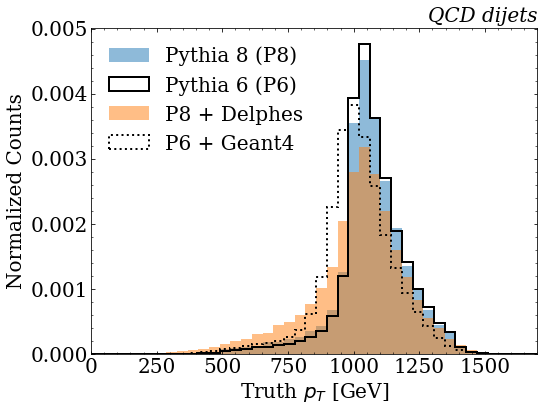

In [51]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(delphes[:,6],density=True,alpha=0.5,bins=np.linspace(0,2000,50),label="Pythia 8 (P8)")
_,_,_=plt.hist(sim.jets_f[:,8],density=True,bins=np.linspace(0,2000,50),histtype="step",color="black",lw=2,label="Pythia 6 (P6)")

_,_,_=plt.hist(delphes[:,1],density=True,alpha=0.5,bins=np.linspace(0,2000,50),label="P8 + Delphes")
_,_,_=plt.hist(sim.jets_f[:,0],density=True,bins=np.linspace(0,2000,50),histtype="step",color="black",ls=":",lw=2,label="P6 + Geant4")

#plt.ylim([0,0.01])
plt.xlim([0,1700])
plt.xlabel("Truth $p_T$ [GeV]")
plt.ylabel("Normalized Counts")
plt.legend(frameon=False,fontsize=20)
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_pT.pdf",bbox_inches='tight')

In [109]:
xvals_1 = np.concatenate([sim.jets_f[:,8],delphes[:,6]])
yvals_1 = np.concatenate([np.ones(len(sim.jets_f[:,8])),np.zeros(len(delphes[:,6]))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

reset_weights(modelP)
modelP.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
hp = modelP.fit(X_train_1,
          Y_train_1,
          epochs=20,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1))

xvals_1 = np.concatenate([np.c_[sim.jets_f[:,8],sim.jets_f[:,0]],np.c_[delphes[:,6],delphes[:,1]]])
yvals_1 = np.concatenate([np.ones(len(sim.jets_f[:,8])),np.zeros(len(delphes[:,6]))])
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(xvals_1, yvals_1)

reset_weights(modelP2)
modelP2.compile(loss="binary_crossentropy",optimizer='Adam',metrics=['accuracy'])
modelP2.fit(X_train_1,
          Y_train_1,
          epochs=50,
          batch_size=1000,
          validation_data=(X_test_1, Y_test_1))

Epoch 1/50
90/90 [==============================] - 0s 3ms/step - loss: 6.4798 - accuracy: 0.7504 - val_loss: 0.4759 - val_accuracy: 0.8348
Epoch 2/50
90/90 [==============================] - 0s 2ms/step - loss: 0.4540 - accuracy: 0.8329 - val_loss: 0.4497 - val_accuracy: 0.8348
Epoch 3/50
90/90 [==============================] - 0s 2ms/step - loss: 0.4602 - accuracy: 0.8329 - val_loss: 0.4841 - val_accuracy: 0.8348
Epoch 4/50
90/90 [==============================] - 0s 3ms/step - loss: 0.4607 - accuracy: 0.8329 - val_loss: 0.4741 - val_accuracy: 0.8348
Epoch 5/50
90/90 [==============================] - 0s 3ms/step - loss: 0.4576 - accuracy: 0.8329 - val_loss: 0.4599 - val_accuracy: 0.8348
Epoch 6/50
90/90 [==============================] - 0s 3ms/step - loss: 0.4772 - accuracy: 0.8329 - val_loss: 0.4685 - val_accuracy: 0.8348
Epoch 7/50
90/90 [==============================] - 0s 3ms/step - loss: 0.7430 - accuracy: 0.7739 - val_loss: 0.4495 - val_accuracy: 0.8348
Epoch 8/50
90/90 [==

In [117]:
wTP = reweight(delphes[:,6],modelP)
wRTP = reweight(np.c_[delphes[:,6],delphes[:,1]],modelP2)
wTG = reweight(sim.jets_f[:,8],modelP)

<ipython-input-157-13184ec64ae1>:13: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(delphes[:,1]/delphes[:,6],alpha=0.5,bins=np.linspace(0,2,50),density=True,label="P8 + Delphes",color="tab:orange")
<ipython-input-157-13184ec64ae1>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.hist(delphes[:,1]/delphes[:,6],bins=np.linspace(0,2,50),density=True,label="P8 + Delphes + Conditional",color="red",histtype="step",ls=":",weights=wRTP/wTP,lw=2)


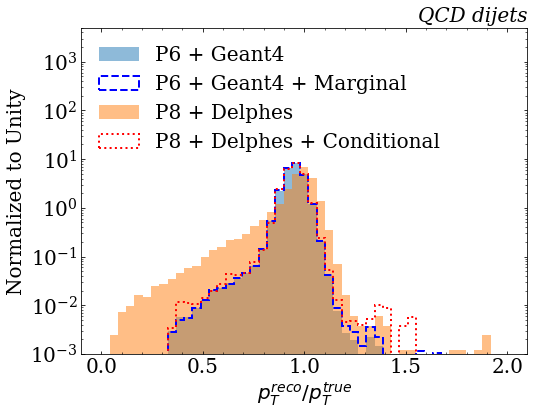

In [157]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(sim.jets_f[:,0]/sim.jets_f[:,8],bins=np.linspace(0,2,50),density=True,label="P6 + Geant4",color="tab:blue",alpha=0.5)
plt.hist(sim.jets_f[:,0]/sim.jets_f[:,8],bins=np.linspace(0,2,50),density=True,label="P6 + Geant4 + Marginal",histtype="step",lw=2,ls="--",color="blue",weights=1./wTG)
plt.hist(delphes[:,1]/delphes[:,6],alpha=0.5,bins=np.linspace(0,2,50),density=True,label="P8 + Delphes",color="tab:orange")
plt.hist(delphes[:,1]/delphes[:,6],bins=np.linspace(0,2,50),density=True,label="P8 + Delphes + Conditional",color="red",histtype="step",ls=":",weights=wRTP/wTP,lw=2)
plt.xlabel("$p_T^{reco}/p_T^{true}$")
plt.ylabel("Normalized to Unity")
plt.yscale("log")
plt.legend(frameon=False,loc="upper left")
plt.ylim([1e-3,5000])
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_R_pT.pdf",bbox_inches='tight')

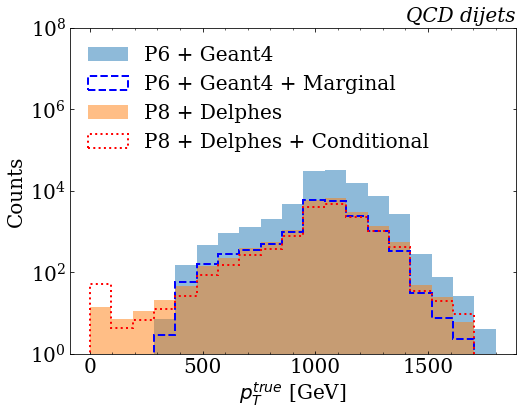

In [158]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(sim.jets_f[:,8],bins=np.linspace(0,1800,20),label="P6 + Geant4",color="tab:blue",alpha=0.5)
plt.hist(sim.jets_f[:,8],bins=np.linspace(0,1800,20),label="P6 + Geant4 + Marginal",histtype="step",color="blue",weights=1./wTG,ls="--",lw=2)
plt.hist(delphes[:,6],bins=np.linspace(0,1800,20),label="P8 + Delphes",color="tab:orange",alpha=0.5)
plt.hist(delphes[:,6],bins=np.linspace(0,1800,20),label="P8 + Delphes + Conditional",color="red",histtype="step",ls=":",weights=wRTP/wTP,lw=2)
plt.xlabel("$p_T^{true}$ [GeV]")
plt.ylabel("Counts")
plt.yscale("log")
plt.legend(frameon=False,loc="upper left")
plt.ylim([1,1e8])
_=plt.title(r"QCD dijets",loc="right",fontsize=20, fontstyle="italic")
plt.savefig("conditional/Dijets_T_pT.pdf",bbox_inches='tight')